In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

Activated C:\Users\mikha\Documents\Introduction2AmplitudeAnalysis\Project.toml
Info Introduction2AmplitudeAnalysis 0.0.1 activated, master requested


In [2]:
using Parameters
using Plots
using DelimitedFiles
using TypedTables
using LinearAlgebra
theme(:wong)

# Kinematics of three-body decay

1. Number degrees of freedom
2. Phase space: 5 d.o.f vs 2 d.o.f
3. Mandelstam invariants: ranges of $m_{ij}^2$
4. Parametrization ($m_{12}$, $\cos\theta$) and ($m_{12}^2$, $m_{23}^2$)
5. Shape of the dalitz plot
6. Angles $\hat{\theta}_{ij}$ and $\theta_{ij}$

## 0. Intro

In [3]:
@with_kw struct ThreeBodySystem
    m0::Float64
    m1::Float64
    m2::Float64
    m3::Float64
    ThreeBodySystem(m0,m1,m2,m3) = m0<m1+m2+m3 ? error("m₀ should be bigger than m₁+m₂+m₃") : new(m0,m1,m2,m3)
end

ThreeBodySystem

In [4]:
tbs = ThreeBodySystem(m1=1,m2=1,m3=1, m0=3.3)

ThreeBodySystem
  m0: Float64 3.3
  m1: Float64 1.0
  m2: Float64 1.0
  m3: Float64 1.0


## 1. Number of degrees of freedom in the $0\to 1,2,3$ reaction

It is a four-legs process, there was some formula,...
$$
\text{#d.o.f.} = 3n-10?
$$
 - So, is it $2$?
 - Are their related to the **Mandelstam** invatiant **variables** I remenber hearing about?
 
 
Well, indeed, the formular $3n-10$ comes from the counting
  * [+3] d.o.f. for every particle
  * [-4] energy-momentum constraints
  * [-3] rotations of the whole system
  * [-3] boosts: we can bring of the particle to the rest frame, e.g. $\vec p_0 = \vec 0$.

## 2. Phase space
The three-body phase space reads
$$
\begin{align}
d\Phi_3 = \prod_{i=1}^3 \left(\frac{d^3 p_i}{(2\pi)^3 2E_i}\right) (2\pi)^4 \delta^4(p_0-p_1-p_2-p_3)
\end{align}
$$
Every particle has three degrees of freedom (four component of four-vector - the mass constraint).
The energy-momentum concervation law removes 4 constrains
$$
\text{# integrals} = 3\cdot 3-4 = 5
$$
$\Rightarrow$ when you deal with the three body system, there are 5 independent variables **at maximum**.

Once there are no *external reference* (like production plate, or polarization direction),
the matrix element cannot depend on the angles of the rotation of the whole system.
 - *think about a fixed configuration of the momenta of the four particles $\vec p_0$, $\vec p_1$, $\vec p_2$, and $\vec p_3$. It is a digid body. It is orientation in the space can be described by the three Euler angles. These are the angles that the matrix element does not depend upon.*


## 3. What are these 2 d.o.f. or 5 d.o.f.
that completely describe the three-body phase space
$$
\begin{align}
d \Phi_3 &= \frac{d m_{12}^2}{2\pi}d\Phi_{2}(0\to X_{12},3) d\Phi_2(X_{12}\to 1,2)\\
 &= \frac{1}{2\pi(8\pi)^2}\,\,\frac{d\phi_3 d\cos\theta_3 d\phi_{12}}{8\pi^2}\,\,
%  \rho(m_0^2,m_{12}^2,m_3^2)\rho(m_{12}^2,m_1^2,m_2^2)
\fbox{$
  \frac{\lambda^{1/2}(m_0^2,m_{12}^2,m_3^2)}{m_0^2}
 \frac{\lambda^{1/2}(m_{12}^2,m_1^2,m_2^2)}{m_{12}^2}
 \frac{d \cos\theta_{12}}{2} d m_{12}^2
 $}\\
 &= \frac{1}{2\pi(8\pi)^2 m_0^2}\,\,\frac{d\alpha d\cos\beta d\gamma}{8\pi^2}\,\,
 \fbox{$d m_{12}^2 d m_{23}^2$}
\end{align}
$$
here are $\theta_{12}$, $\phi_{12}$ are the sperical angles for $X_{12}\to 1,2$ "transition" (no dynamics, purely mathematical composition).

In [5]:
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x

λ (generic function with 1 method)

***Exercise***: plot the function $\sqrt{\lambda\lambda}$, find the limits of $m_{12}$

## 4. Relation between $\cos\theta$ and $\sigma_k\equiv m_{ij}^2$

Convenient names for the combination of invariant masses
$$
\begin{align}
\sigma_1 &\equiv m_{23}^2 = (p_2+p_3)^2 &
\sigma_2 &\equiv m_{31}^2 = (p_3+p_1)^2 &
\sigma_3 &\equiv m_{12}^2 = (p_1+p_2)^2
\end{align}
$$
only two are independent: 
$$
\sigma_1+\sigma_2+\sigma_3 = m_0^2+m_1^2+m_2^2+m_3^2
$$
The different sets of independent variables:
 * $(\sigma_1,\sigma_2)$ OR $(\sigma_2,\sigma_3)$ or $(\sigma_3,\sigma_1)$
 * $(\sigma_1,\cos\theta_{23})$, or ...
 
Reminder: the $\theta_{12}$ is the polar angle,
 - the angle of particle 1, in the rest frame frame of (12)
 - the angle of $\vec p_1$ with respect to z: $\vec z = -\vec{p}_3$.

In [6]:
@with_kw struct Invariants
    σ1::Float64
    σ2::Float64
    σ3::Float64
end

Invariants

In [7]:
sumsq(tbs::ThreeBodySystem) = tbs.m0^2+tbs.m1^2+tbs.m2^2+tbs.m3^2
function Invariants(tbs::ThreeBodySystem;σ1=-1.0,σ2=-1.0,σ3=-1.0)
    sign(σ1)+sign(σ2)+sign(σ3)!=1 && error("the method works with TWO invariants given")
    σ3 < 0 && return Invariants(;σ1,σ2,σ3=sumsq(tbs)-σ1-σ2)
    σ1 < 0 && return Invariants(;σ2,σ3,σ1=sumsq(tbs)-σ2-σ3)
    σ2 < 0 && return Invariants(;σ3,σ1,σ2=sumsq(tbs)-σ3-σ1)
end

Invariants

In [8]:
function σ2of1(cosθ23, σ1; tbs::ThreeBodySystem)
    @unpack m0, m1, m2, m3 = tbs
    return m3^2 + m1^2 + (σ1+m3^2-m2^2)*(m0^2-m1^2-σ1)/(2σ1) -
        sqrt(λ(m0^2,m1^2,σ1)*λ(m2^2,m3^2,σ1))/(2σ1)*cosθ23
end
# finish
# 
# function cosθ23(σs::Invariants, tbs::ThreeBodySystem)
# end

σ2of1 (generic function with 1 method)

### 5. Shape of the Dalitz Plot

In [9]:
Kibble(σs::Invariants,tbs::ThreeBodySystem) = λ(λ(tbs.m0^2,tbs.m1^2,σs.σ1),
                                                λ(tbs.m0^2,tbs.m2^2,σs.σ2),
                                                λ(tbs.m0^2,tbs.m3^2,σs.σ3))

Kibble (generic function with 1 method)

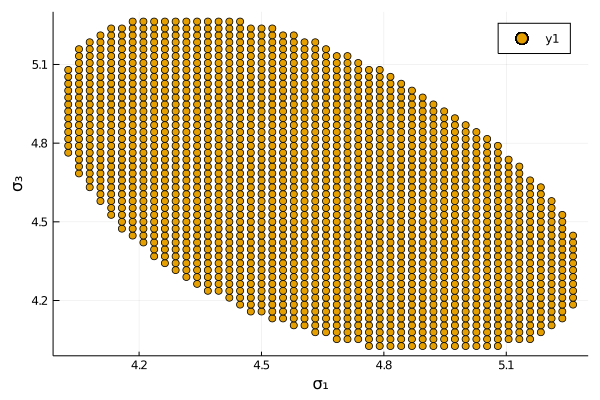

In [10]:
let
    @unpack m0, m1, m2, m3 = tbs
    σ1v = range((m2+m3)^2, (m0-m1)^2, length=50)
    σ3v = range((m1+m2)^2, (m0-m3)^2, length=50)
    calv = [(;σ1,σ3) for σ3 in σ3v, σ1 in σ1v]
    in_ph_region = filter(v->Kibble(Invariants(tbs;v...), tbs) < 0, calv)
    scatter(Tuple.(in_ph_region), xlab="σ₁", ylab="σ₃")
end

***Exercise***: the exact shape of the dalits
 - plot the border line (Hint: $\cos\theta=\pm 1$)
 - fill in with the color `plot(x, y1, fill_between=y2)`
 - change the masses, find the condition for the two shapes
  * an ellipce
  * a triangle
  * a thin line

***Final Exercise***: the data for the decay of $B^+$
 Find $m_1$, $m_2$, $m_3$, identify the reaction

In [11]:
const mBp = 5.27934;

In [12]:
# t = let
#     M = readdlm(joinpath("data", "secret_dalitz_Bplus.txt"))
#     Table(σ1 = M[:,1], σ2 = M[:,2])
# end

In [13]:
# scatter(t.σ1, t.σ2)

## 6. Other frames and other angles